# Knn Clustering

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


In [118]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [119]:
df = pd.read_csv('../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
df.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,CRS_ARR_M,Temperature,Dew Point,Humidity,...,Condition_Light Snow / Windy,Condition_Mostly Cloudy,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Snow,Condition_Wintry Mix,Condition_Wintry Mix / Windy
0,11,1,5,124,636,324,448,48,34,58,...,False,False,False,False,False,False,False,False,False,False
1,11,1,5,371,2475,340,531,48,34,58,...,False,False,False,False,False,False,False,False,False,False
2,11,1,5,181,1069,301,482,48,34,58,...,False,False,False,False,False,False,False,False,False,False
3,11,1,5,168,944,345,513,48,34,58,...,False,False,False,False,False,False,False,False,False,False
4,11,1,5,139,760,360,499,46,32,58,...,False,False,False,False,False,False,False,False,False,False


### Remove Outilers from target variable

In [120]:
dep_delay = df['DEP_DELAY']
mean = dep_delay.mean()
sd = dep_delay.std()

outliers = ((dep_delay < mean-3*sd) | (dep_delay > mean+3*sd))
df[outliers]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,CRS_ARR_M,Temperature,Dew Point,Humidity,...,Condition_Light Snow / Windy,Condition_Mostly Cloudy,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Snow,Condition_Wintry Mix,Condition_Wintry Mix / Windy


In [121]:
X = df.drop(columns=['DEP_DELAY'])  # Feature matrix
y = df['DEP_DELAY']  # Target variable

### Feature Selection

In [122]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/tmp/ipykernel_9170/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [123]:
from sklearn.feature_selection import chi2, SelectKBest 
# Perform Chi-Square test 
chi2_selector = SelectKBest(score_func=chi2, k=12) 
X_selected = chi2_selector.fit_transform(X, y) # Get selected feature names 
selected_features = X.columns[chi2_selector.get_support()] 
print("Selected Features:", selected_features.tolist())

Selected Features: ['MONTH', 'DAY_OF_MONTH', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_M', 'CRS_ARR_M', 'Humidity', 'Wind Speed', 'Wind Gust', 'sch_dep', 'OP_UNIQUE_CARRIER_B6', 'Condition_Rain']


In [124]:
chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns)
sorted_chi2_scores = chi2_scores.sort_values(ascending=False) 
print(chi2_scores.sort_values(ascending=False))

CRS_DEP_M           49170.189663
DISTANCE            17937.129663
CRS_ARR_M            6374.272257
CRS_ELAPSED_TIME     1920.355634
Wind Gust            1336.043846
                        ...     
DEST_PIT                0.031091
DEST_CVG                0.016443
DEST_RDU                0.005127
DEST_SAV                0.004111
DEST_SJC                0.001949
Length: 110, dtype: float64


In [125]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = 0.25, random_state = 42)

In [126]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

In [127]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [128]:
y_pred = neigh.predict(X_test)

In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 0.11
Mean Absolute Error (MAE): 0.20
R-Squared (R2): 0.0510


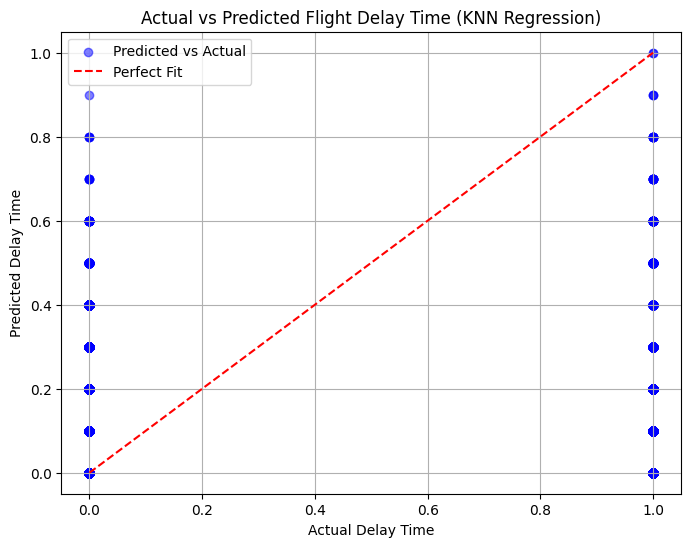

In [130]:
# Plot Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Delay Time")
plt.ylabel("Predicted Delay Time")
plt.title("Actual vs Predicted Flight Delay Time (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()